In [10]:
# Imports
import pandas as pd

from dslabs_functions import (
    get_variable_types,plot_multibar_chart,
    mvi_by_filling,
    evaluate_approach)

from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from pandas import read_csv, DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)
from sklearn.model_selection import train_test_split


In [12]:
# Read
filename = 'class_pos_covid_derived.csv'
file_tag = 'covid_fig_'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


variable_types = get_variable_types(data)
symbolic: list[str] = variable_types["symbolic"]
data[symbolic] = data[symbolic].apply(lambda x: x.astype("category"))
variables_types: dict[str, list] = get_variable_types(data)
# TODO why is Sex not in categorical?


In [13]:
state_values =  { 
    "Alabama": [32.318230, -86.902298],
    "Alaska": [66.160507, -153.369141],
    "Arizona": [34.048927, -111.093735],
    "Arkansas": [34.799999, -92.199997],
    "California": [36.778259, -119.417931],
    "Colorado": [39.113014, -105.358887],
    "Connecticut": [41.599998, -72.699997],
    "Delaware": [39.0, -75.5],
    "District of Columbia": [38.9072, -77.0369],
    "Florida": [27.994402, -81.760254],
    "Georgia": [33.247875, -83.441162],
    "Guam": [13.444304, 144.793732],
    "Hawaii": [19.741755, -155.844437],
    "Idaho": [44.068203, -114.742043],
    "Illinois": [40.0, -89.0],      
    "Indiana": [40.273502, -86.126976],
    "Iowa": [42.032974, -93.581543],
    "Kansas": [38.5, -98.0],
    "Kentucky": [37.839333, -84.270020],
    "Louisiana": [30.391830, -92.329102],
    "Maine": [45.367584, -68.972168],
    "Maryland": [39.045753, -76.641273],
    "Massachusetts": [42.407211, -71.382439],
    "Michigan": [44.182205, -84.506836],
    "Minnesota": [46.392410, -94.636230],
    "Mississippi": [33.0, -90.0],
    "Missouri": [38.573936, -92.603760],
    "Montana": [46.965260, -109.533691],
    "Nebraska": [41.500000, -100.000000],
    "Nevada": [39.876019, -117.224121],
    "New Hampshire": [44.0, -71.5],
    "New Jersey": [39.833851, -74.871826],
    "New Mexico": [34.307144, -106.018066],
    "New York": [43.000000, -75.000000],
    "North Carolina": [35.782169, -80.793457],
    "North Dakota": [47.650589, -100.437012],
    "Ohio": [40.367474, -82.996216],
    "Oklahoma": [36.084621, -96.921387],
    "Oregon": [44.000000, -120.500000],
    "Pennsylvania": [41.203323, -77.194527],
    "Puerto Rico": [18.2208, -66.5901],
    "Rhode Island": [41.700001, -71.500000],
    "South Carolina": [33.836082, -81.163727],
    "South Dakota": [44.500000, -100.000000],
    "Tennessee": [35.860119, -86.660156],
    "Texas": [31.000000, -100.000000],
    "Utah": [39.419220, -111.950684],
    "Vermont": [44.000000, -72.699997],
    "Virginia": [37.926868, -78.024902],
    "Virgin Islands": [18.3358, -64.8963],
    "Washington": [47.751076, -120.740135],
    "West Virginia": [39.000000, -80.500000],
    "Wisconsin": [44.500000, -89.500000],
    "Wyoming": [43.075970, -107.290283]
}

# create two new columns in the dataframe with the latitude and longitude values
data["Latitude"] = data["State"].apply(lambda x: state_values[x][0])
data["Longitude"] = data["State"].apply(lambda x: state_values[x][1])
min_long = abs(data["Longitude"].min())
data["Longitude"] = data["Longitude"].apply(lambda x: x + min_long) # to not have negative values for the models

data.drop(['State'], axis=1, inplace=True)
# 0.2s

In [14]:
# GeneralHealth ['Very good', 'Good', 'Excellent', 'Poor', 'Fair']
general_values = {
    "Excellent": 4,
    "Very good": 3,
    "Good": 2,
    "Fair": 1,
    "Poor": 0,
}

# LastCheckupTime ['Within past year (anytime less than 12 months ago)', 'Within past 2 years (1 year but less than 2 years ago)', '5 or more years ago', 'Within past 5 years (2 years but less than 5 years ago)']
last_values = {
    "Within past year (anytime less than 12 months ago)": 0,
    "Within past 2 years (1 year but less than 2 years ago)": 1,
    "Within past 5 years (2 years but less than 5 years ago)": 2,
    "5 or more years ago": 3,
}

# RemovedTeeth ['None of them', '1 to 5', '6 or more, but not all', 'All']
teeth_values = {
    "None of them": 0,
    "1 to 5": 1,
    "6 or more, but not all": 2,
    "All": 3,
}

# HadDiabetes ['No',  'Yes',  'Yes, but only during pregnancy (female)', 'No, pre-diabetes or borderline diabetes']
diabetes_values = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 1,
    'Yes, but only during pregnancy (female)': 2,
    'Yes': 3,
}

# SmokerStatus ['Former smoker', 'Never smoked', 'Current smoker - now smokes every day', 'Current smoker - now smokes some days']
smoker_values = {
    'Never smoked': 0,
    'Former smoker': 1,
    'Current smoker - now smokes some days': 2,
    'Current smoker - now smokes every day': 3,
}

# ECigaretteUsage ['Never used e-cigarettes in my entire life', 'Use them some days', 'Not at all (right now)', 'Use them every day']
ecig_values = {
    'Never used e-cigarettes in my entire life': 0,
    'Not at all (right now)': 1,
    'Use them some days': 2,
    'Use them every day': 3,
}

# TODO confirm this
# RaceEthnicityCategory ['White only, Non-Hispanic', 'Black only, Non-Hispanic', 'Multiracial, Non-Hispanic', 'Other race only, Non-Hispanic', 'Hispanic']
race_values = {
    'White only, Non-Hispanic': 0,
    'Black only, Non-Hispanic': 1,
    'Multiracial, Non-Hispanic': 2,
    'Other race only, Non-Hispanic': 3,
    'Hispanic': 4,
}

# "AgeCategory ['Age 65 to 69', 'Age 70 to 74', 'Age 80 or older', 'Age 50 to 54', 'Age 75 to 79', 'Age 60 to 64', 'Age 55 to 59', 'Age 45 to 49', 'Age 40 to 44', 'Age 25 to 29', 'Age 30 to 34', 'Age 18 to 24', 'Age 35 to 39']"
age_values = {
    'Age 18 to 24': 0,
    'Age 25 to 29': 1,
    'Age 30 to 34': 2,
    'Age 35 to 39': 3,
    'Age 40 to 44': 4,
    'Age 45 to 49': 5,
    'Age 50 to 54': 6,
    'Age 55 to 59': 7,
    'Age 60 to 64': 8,
    'Age 65 to 69': 9,
    'Age 70 to 74': 10,
    'Age 75 to 79': 11,
    'Age 80 or older': 12,
}

# TODO confirm if this is the best way to do this
# "TetanusLast10Tdap ['Yes, received Tdap', 'Yes, received tetanus shot but not sure what type', 'No, did not receive any tetanus shot in the past 10 years', 'Yes, received tetanus shot, but not Tdap']"
tetanus_values = {
    'No, did not receive any tetanus shot in the past 10 years': 0,
    'Yes, received tetanus shot, but not Tdap': 1,
    'Yes, received tetanus shot but not sure what type': 2,
    'Yes, received Tdap': 3,
}


encoding: dict[str, dict[str, int]] = {
    "GeneralHealth": general_values,
    "LastCheckupTime": last_values,
    "RemovedTeeth": teeth_values,
    "HadDiabetes": diabetes_values,
    "SmokerStatus": smoker_values,
    "ECigaretteUsage": ecig_values,
    "RaceEthnicityCategory": race_values,
    "AgeCategory": age_values,
    "TetanusLast10Tdap": tetanus_values,
    # "Region": region_values, TODO have to confirm this
    # "AgeGroup": age_group_values,
}

data = data.replace(encoding, inplace=False)
data.head()

# drop age group and region
data.drop(['AgeGroup', 'Region'], axis=1, inplace=True)

In [15]:
binaries = variable_types["binary"]

# make all the binary variables fine for classification
for binary in binaries:
    data[binary] = data[binary].apply(lambda x: 1 if x == "Yes" else x)
    data[binary] = data[binary].apply(lambda x: 0 if x == "No" else x)
    data[binary] = data[binary].apply(lambda x: 0 if x == "Female" else x)
    data[binary] = data[binary].apply(lambda x: 1 if x == "Male" else x)


In [16]:
# save data to csv
data.to_csv('class_pos_covid_derived_prepared.csv', index=False)

### Missing Values
#### Drop

In [17]:
# read class_pos_covid_derived_prepared
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


In [18]:
print(data.shape)

df: DataFrame = data.dropna(how="any", inplace=False)
print(df.shape)


(380932, 41)
(237630, 41)


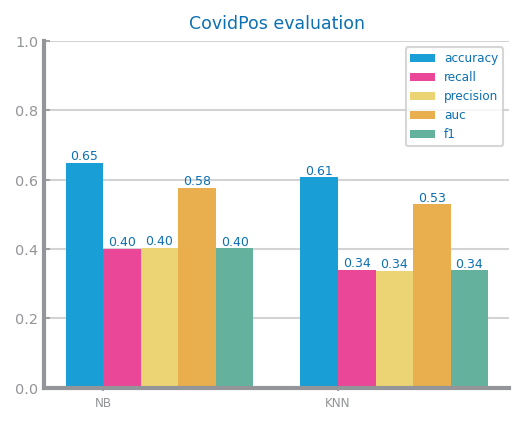

In [19]:
# dropna
data.dropna(inplace=True)
target = "CovidPos"
file_tag = "CovidPos"
# use train test split to create the train and test sets using data variable
train: DataFrame = data.sample(frac=0.7, random_state=1)
test: DataFrame = data.drop(train.index)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()
# 3m 30s

#### Filling with dummy value (usually: NaN, -1 or 0 for numeric, 'NA' for symbolic and False for boolean)

In [20]:
# read class_pos_covid_derived_prepared
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


In [21]:
# show aa row that has a missing value
data[data.isnull().any(axis=1)].head(1)

# get variable types
variable_types = get_variable_types(data)

# all the missing values of the binary variables are filled with 0
binaries = variable_types["binary"]
data[binaries] = data[binaries].apply(lambda x: x.fillna(0))

# all the missing values of the numeric (and categorical bcs already changed them) variables are filled with 999 because it cant be a negative value... TODO ceck if this makes sense
numeric: list[str] = variable_types["numeric"]
data[numeric] = data[numeric].apply(lambda x: x.fillna(999)) 

print(data.shape)
data.shape

(380932, 41)


(380932, 41)

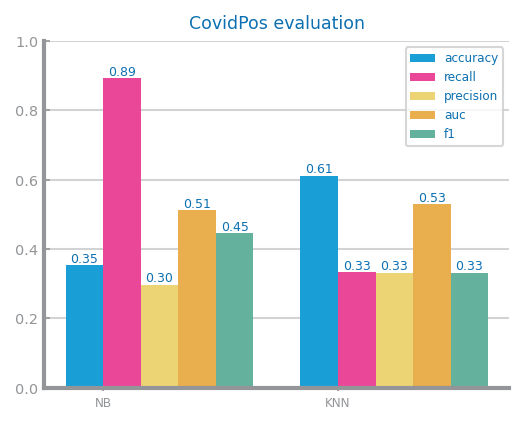

In [22]:
# dropna
data.dropna(inplace=True)
target = "CovidPos"
file_tag = "CovidPos"
# use train test split to create the train and test sets using data variable
train: DataFrame = data.sample(frac=0.7, random_state=1)
test: DataFrame = data.drop(train.index)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval_dummy.png")
show()
# 8m 30s

#### Filling with mean and most_frequent value

In [23]:
# read class_pos_covid_derived_prepared
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


In [24]:
# TODO check one examploe to see if its working

categorical = ["GeneralHealth", "LastCheckupTime", "RemovedTeeth", "HadDiabetes", "SmokerStatus", "ECigaretteUsage", "RaceEthnicityCategory", "AgeCategory", "TetanusLast10Tdap", "Longitude", "Latitude"]
# fill missing values with the most frequent value
for cat in categorical:
    frequent_value = data[cat].mode()[0]
    data[cat] = data[cat].fillna(frequent_value)

# fill the missing values with the mean of that column
numeric = "PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"
for num in numeric:
    mean_value = data[num].mean()
    data[num] = data[num].fillna(mean_value)

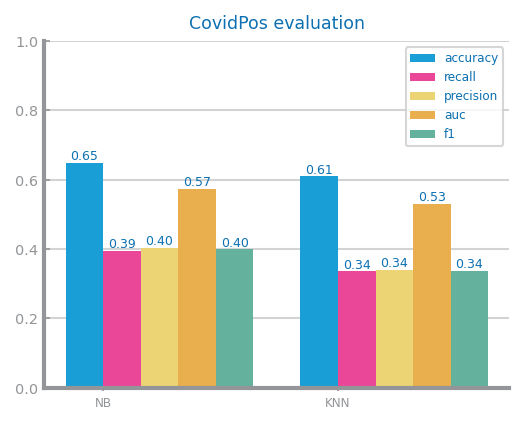

In [25]:
# dropna
data.dropna(inplace=True)
target = "CovidPos"
file_tag = "CovidPos"
# use train test split to create the train and test sets using data variable
train: DataFrame = data.sample(frac=0.7, random_state=1)
test: DataFrame = data.drop(train.index)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval_mean_frequent.png")
show()
# 8m 30s

#### Filling with median and most_frequent value

In [26]:
# read class_pos_covid_derived_prepared
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


In [27]:
# TODO check one examploe to see if its working

categorical = ["GeneralHealth", "LastCheckupTime", "RemovedTeeth", "HadDiabetes", "SmokerStatus", "ECigaretteUsage", "RaceEthnicityCategory", "AgeCategory", "TetanusLast10Tdap", "Longitude", "Latitude"]
# fill missing values with the most frequent value
for cat in categorical:
    frequent_value = data[cat].mode()[0]
    data[cat] = data[cat].fillna(frequent_value)

# fill the missing values with the mean of that column
numeric = "PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"
for num in numeric:
    median_value = data[num].median()
    data[num] = data[num].fillna(median_value)

In [83]:
# dropna
data.dropna(inplace=True)
target = "CovidPos"
file_tag = "CovidPos"
# use train test split to create the train and test sets using data variable
train: DataFrame = data.sample(frac=0.7, random_state=1)
test: DataFrame = data.drop(train.index)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval_median_frequent.png")
show()
# 8m 30s

### Choosen MV imputation

In [56]:
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')

categorical = ["GeneralHealth", "LastCheckupTime", "RemovedTeeth", "HadDiabetes", "SmokerStatus", "ECigaretteUsage", "RaceEthnicityCategory", "AgeCategory", "TetanusLast10Tdap", "Longitude", "Latitude"]
for cat in categorical:
    frequent_value = data[cat].mode()[0]
    data[cat] = data[cat].fillna(frequent_value)

# fill the missing values with the mean of that column
numeric = "PhysicalHealthDays", "MentalHealthDays", "SleepHours", "HeightInMeters", "WeightInKilograms", "BMI"
for num in numeric:
    median_value = data[num].median()
    data[num] = data[num].fillna(median_value)
data.to_csv('class_mv_imputed.csv',index=False)

### Drop outliers

In [62]:

file_tag = 'CovidPos'
data: DataFrame =  pd.read_csv('class_mv_imputed.csv', sep=',', decimal='.', na_values='')
data_train, data_test = train_test_split(data, test_size=0.2)
print(data_test.shape)
print(f"Original data: {data_train.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data_train)["numeric"]
if numeric_vars is not None:
    df: DataFrame = data_train.copy(deep=True)
    summary5: DataFrame = data_train[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var]
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"./{file_tag}_train_drop_outliers.csv", index=False)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")


(76187, 41)
Original data: (304745, 41)
Data after dropping outliers: (136354, 41)


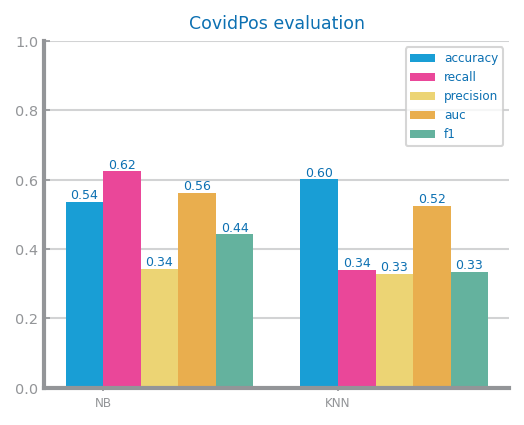

In [58]:
target = "CovidPos"
file_tag = "CovidPos"
test = data_test.copy(deep=True)
df.dropna(inplace=True)
test.dropna(inplace=True)

figure()
eval: dict[str, list] = evaluate_approach(df,test , target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_drop_outliers.png")
show()

### Replacing outliers

In [65]:

if [] != numeric_vars:
    df_rep: DataFrame = data_train.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df_rep[var].median()
        df_rep[var] = df_rep[var].apply(lambda x: median if x > top or x < bottom else x)
    df_rep.to_csv(f"./{file_tag}_replacing_outliers.csv", index=False)
    print("Data after replacing outliers:", df_rep.shape)
    print(df_rep.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (304745, 41)
                 Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
count  304745.000000  304745.000000        304745.00000     304745.000000   
mean        0.471565       2.515050             1.77703          2.192833   
std         0.499192       0.917031             4.00403          4.556272   
min         0.000000       1.000000             0.00000          0.000000   
25%         0.000000       2.000000             0.00000          0.000000   
50%         0.000000       2.000000             0.00000          0.000000   
75%         1.000000       3.000000             2.00000          2.000000   
max         1.000000       4.000000            21.00000         21.000000   

       LastCheckupTime  PhysicalActivities     SleepHours   RemovedTeeth  \
count    304745.000000       304112.000000  304745.000000  304745.000000   
mean          0.092996            0.758734       7.026432       0.501245   
std           0.290427            

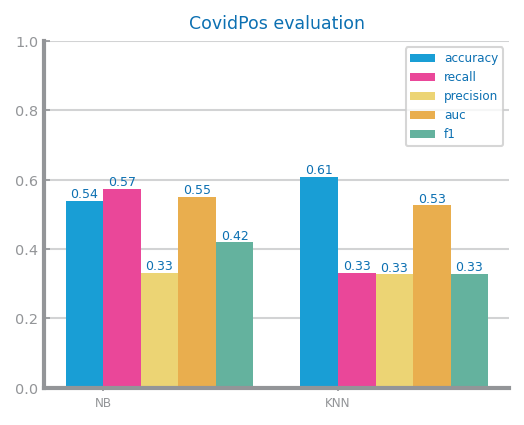

In [69]:
test = data_test.copy(deep=True)
df_rep.dropna(inplace=True)
test.dropna(inplace=True)
figure()
eval: dict[str, list] = evaluate_approach(df_rep,test , target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_replace_outliers.png")
show()

